In [1]:
import torch
import torchsde
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Heston Process

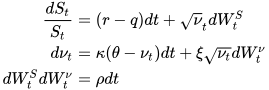

In [2]:
NUM_TIMES = 30

The idea is to train a model that learns to distinguish between
* real-world stock prices
* Heston-SDE paths

Each Heston-SDE path is associated with an $(r, q, \kappa, \theta, \xi, \rho)$ and therefore the model would implicitly give the likelihood of this tuple.

In [3]:
class Heston(torch.nn.Module):

    noise_type = 'general'
    sde_type = 'ito'
    state_size = 2
    brownian_size = 1

    def __init__(self, r, kappa, theta, xi, q=0.0, rho=0.0, sample_size=128):
        super().__init__()
        self.r = torch.nn.Parameter(torch.tensor(r))
        self.q = torch.nn.Parameter(torch.tensor(q))
        self.kappa = torch.nn.Parameter(torch.tensor(kappa))
        self.theta = torch.nn.Parameter(torch.tensor(theta))
        self.xi = torch.nn.Parameter(torch.tensor(xi))
        self.rho = torch.nn.Parameter(torch.tensor(rho))  # TODO
        self.sample_size = sample_size

    def f(self, t, y):
        multiplicator = torch.tensor([self.r - self.q, - self.kappa])
        summand = torch.tensor([0, self.kappa * self.theta])
        drift = torch.mul(multiplicator, y)
        drift += summand
        return drift.view(self.sample_size, self.state_size)

    def g(self, t, y):
        diffusion_1 = torch.sqrt(y[:, -1])
        diffusion_2 = self.xi * torch.sqrt(y[:, -1])
        diffusion = torch.stack([diffusion_1, diffusion_2], dim=-1)
        return diffusion.view(self.sample_size, self.state_size, self.brownian_size)


In [4]:
def get_parameters(ticker):
    start, end = datetime.today() - timedelta(days=3 * 360), datetime.today()
    ticker_data = yf.download(ticker, start=start, end=end)
    prices = ticker_data["Adj Close"]
    ticker_data["Daily Return"] = prices.pct_change()
    ticker_data["Instant Volatility"] = ticker_data["Daily Return"].ewm(span=10, adjust=False).std()
    ticker_data["theta"] = ticker_data["Daily Return"].ewm(span=250, adjust=False).std()
    ticker_data["xi"] = ticker_data["Instant Volatility"].ewm(span=10, adjust=False).std()
    kappas = [0 for i in range(99)]
    for i in range(len(prices) - 99):
        window_returns = prices[i:i + 100]
        lagged_returns = np.roll(window_returns, 1)
        lagged_returns[0] = 0
        X = sm.add_constant(lagged_returns)
        model = sm.OLS(window_returns, X)
        results = model.fit()
        phi = results.params[1]
        kappa = - np.log(abs(phi))
        kappas.append(kappa)
    ticker_data[["kappa"]] = np.asarray(kappas).reshape(-1, 1)
    annual_rate = yf.download("^IRX")["Adj Close"]
    ticker_data["r"] = (1 + annual_rate / 100) ** (1 / 360) - 1
    ticker_data["q"] = yf.Ticker(ticker, start).dividends
    return ticker_data.fillna(0)

[*********************100%***********************]  1 of 1 completed
/var/folders/vh/mv3ytp3x2_jg2tcq53sq9f240000gn/T/ipykernel_1780/550236923.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  phi = results.params[1]
[*********************100%***********************]  1 of 1 completed
$NVDQ: possibly delisted; no price data found  (1d 1925-10-04 -> 2024-09-09)
/var/folders/vh/mv3ytp3x2_jg2tcq53sq9f240000gn/T/ipykernel_1780/550236923.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return ticker_data.fillna(0)


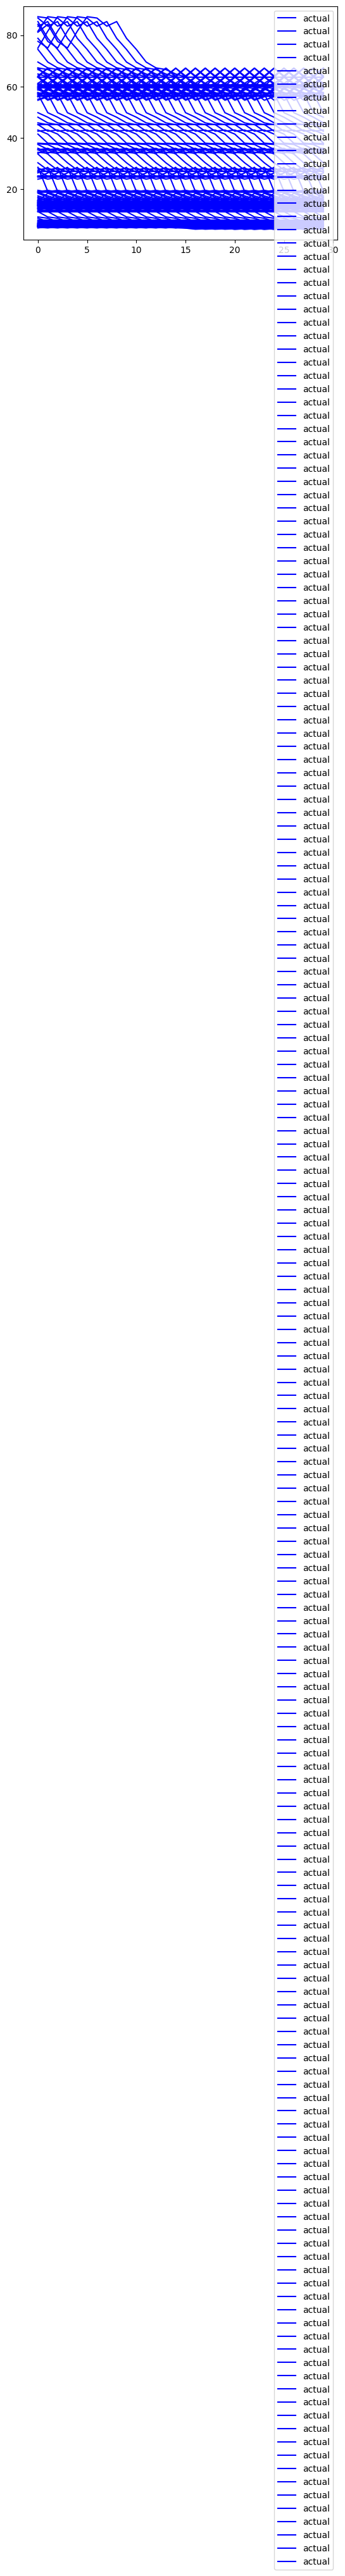

In [5]:
tickers = pd.read_csv("bats_symbols.csv")["Name"]
parameter_names = ["r", "q", "theta", "xi", "kappa"]
for ticker in tickers:
    
    parameters = get_parameters(ticker)
    trajectories, volatilities = [], []
    for date, data in parameters.iterrows():
        future_prices = parameters.loc[[date + timedelta(days=i) for i in range(2 * NUM_TIMES) if date + timedelta(days=i) in parameters.index], "Adj Close"]
        if len(future_prices) >= NUM_TIMES:
            trajectories.append(list(future_prices[:NUM_TIMES]))
            volatilities.append(data["Instant Volatility"])
    trajectories = torch.tensor(trajectories)

    sde = Heston(sample_size=len(trajectories), r=parameters["r"].mean(), q=parameters["q"].mean(), theta=parameters["theta"].mean(), xi=parameters["xi"].mean(), kappa=parameters["kappa"].mean())
    y0 = torch.stack([trajectories[:, 0], torch.tensor(volatilities)], dim=-1)
    ts = torch.linspace(0, 1, NUM_TIMES)
    ys = torchsde.sdeint(sde, y0, ts)[..., 0]

    plt.plot(trajectories.transpose(0, 1).detach(), color="blue", label="actual")
    #plt.plot(ys.detach(), color="red", label="SDE")
    plt.legend()
    plt.show()
    
    break